<a href="https://colab.research.google.com/github/Anikrage/EEG-Classification-using-Self-Supervised-Diffusion-Convolutional-Graph-Neural-Network/blob/prototype/Res1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Dataset

In [35]:
import pandas as pd
import numpy as np

# Load data in chunks to handle large size
chunksize = 10000  # Adjust this size as needed
file_path = '/content/drive/MyDrive/eeg_mdd_dataset/eeg_dataset.csv'

# Initialize lists to collect chunks
data_chunks = []

# Read the CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Preprocess each chunk
    chunk['Group'] = chunk['Group'].map({'H': 0, 'MDD': 1})  # Encode labels
    data_chunks.append(chunk)

# Concatenate all chunks
data= pd.concat(data_chunks, axis=0)

# Check the data
print(data.head())


     Fp1-LE     F3-LE     C3-LE     P3-LE     O1-LE     F7-LE     T3-LE  \
0 -0.000005 -0.000009 -0.000012 -0.000011 -0.000002 -0.000010 -0.000008   
1 -0.000007 -0.000012 -0.000021 -0.000017 -0.000009 -0.000015 -0.000012   
2 -0.000009 -0.000015 -0.000029 -0.000021 -0.000013 -0.000021 -0.000016   
3 -0.000008 -0.000016 -0.000033 -0.000021 -0.000015 -0.000024 -0.000022   
4 -0.000005 -0.000013 -0.000028 -0.000018 -0.000014 -0.000021 -0.000026   

      T5-LE     Fz-LE        Fp2-LE  ...         T4-LE         T6-LE  \
0 -0.000012 -0.000009 -1.310000e-05  ... -8.650000e-06 -3.350000e-06   
1 -0.000014 -0.000011 -1.400000e-05  ... -8.750000e-06 -2.650000e-06   
2 -0.000015 -0.000012 -1.130000e-05  ... -6.450000e-06 -8.500000e-07   
3 -0.000016 -0.000011 -6.250000e-06  ... -2.950000e-06  1.150000e-06   
4 -0.000016 -0.000007 -1.500000e-07  ...  2.500000e-07  2.950000e-06   

      Cz-LE     Pz-LE         A2-A1   23A-23R   24A-24R  Group  Subject ID  \
0 -0.000015 -0.000008 -2.150000e-06 -0

In [38]:
# Select only the EEG data columns (assuming they are named 'Fp1-LE', 'F3-LE', etc.)
eeg_data = data[['Fp1-LE', 'F3-LE', 'C3-LE', 'P3-LE', 'O1-LE', 'F7-LE', 'T3-LE', 'T5-LE',
                      'Fz-LE', 'Fp2-LE', 'F4-LE', 'C4-LE', 'P4-LE', 'O2-LE', 'F8-LE', 'T4-LE',
                      'T6-LE', 'Cz-LE', 'Pz-LE', 'A2-A1', '23A-23R', '24A-24R']]

   # Now 'eeg_data' contains only the EEG signals and can be used for artifact removal, filtering, etc.

Artifact Removal using ICA


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


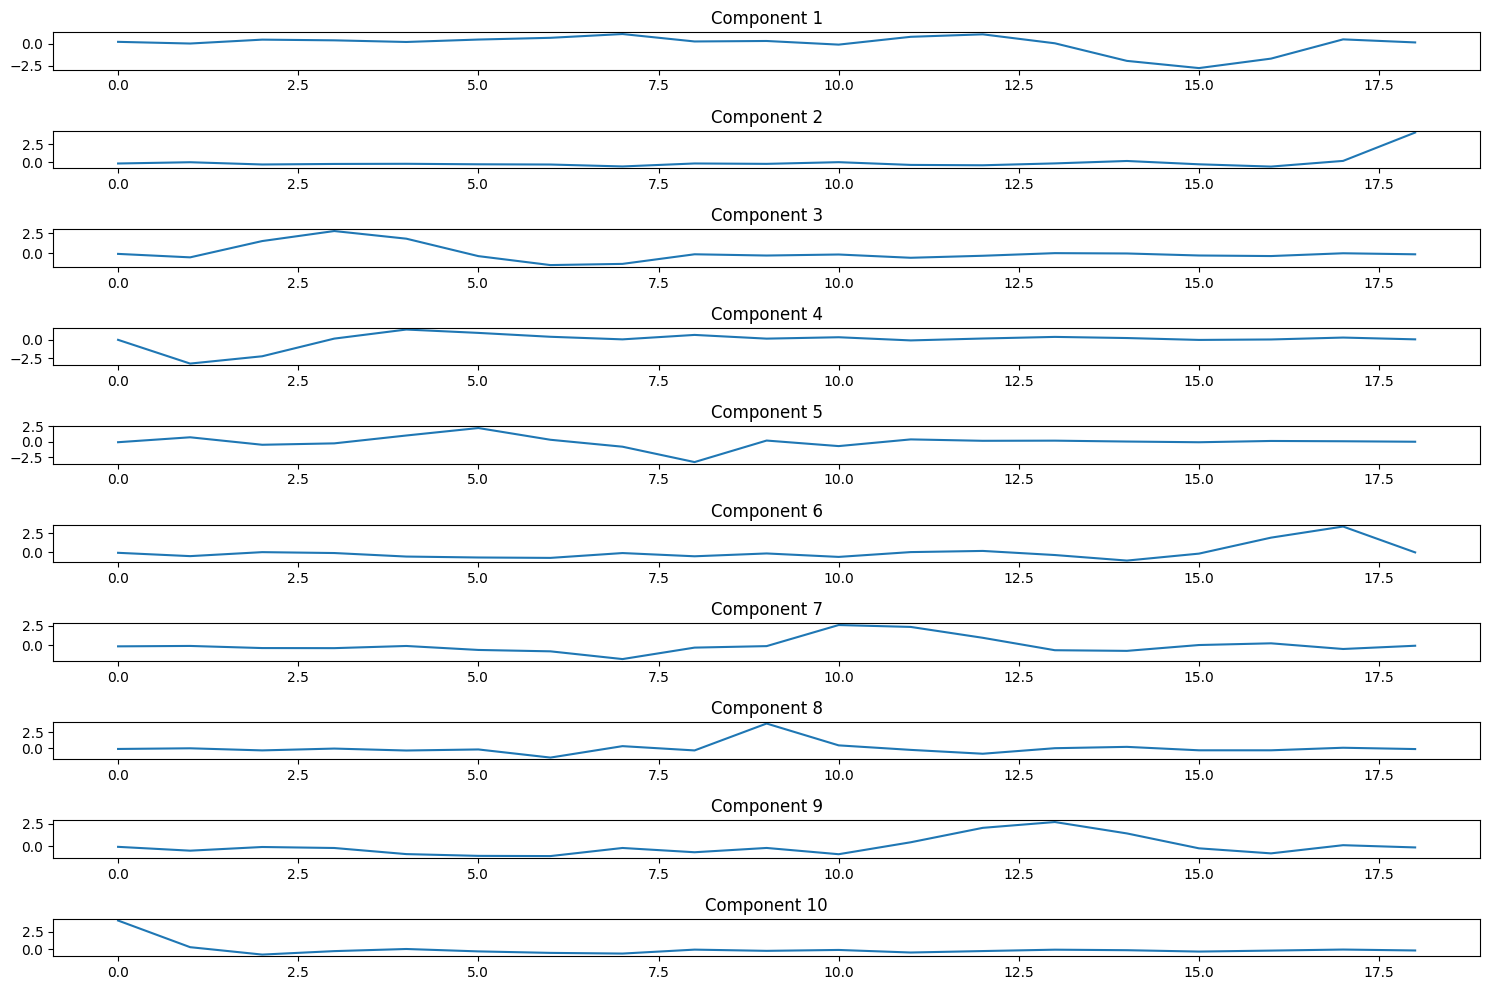

In [39]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt

def remove_artifacts(df, n_components=10):
    eeg_data = df.iloc[:, :-3].values  # Exclude non-EEG columns
    ica = FastICA(n_components=n_components, random_state=42)
    components = ica.fit_transform(eeg_data)

    # Plot the components to visually inspect (optional)
    plt.figure(figsize=(15, 10))
    for i in range(n_components):
        plt.subplot(n_components, 1, i+1)
        plt.plot(components[:, i])
        plt.title(f'Component {i+1}')
    plt.tight_layout()
    plt.show()

    # Assume artifact components have been identified (manual or automatic process)
    # Here we use a simple thresholding for demonstration, but in practice,
    # it should involve careful analysis.
    artifact_indices = []  # Example: identify based on criteria or manual inspection

    # Remove the artifact components
    components[:, artifact_indices] = 0

    # Reconstruct the cleaned EEG signal
    cleaned_eeg_data = ica.inverse_transform(components)

    return pd.DataFrame(cleaned_eeg_data, columns=df.columns[:-3])

# Apply the artifact removal
data_cleaned = remove_artifacts(eeg_data, n_components=10)


Frequency Filtering

In [40]:
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut=0.5, highcut=45.0, fs=128, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

data_filtered = bandpass_filter(data_cleaned.values)



In [50]:
# Convert data_filtered back to a DataFrame before adding the columns
data_filtered = pd.DataFrame(data_filtered, columns=data_cleaned.columns[:data_filtered.shape[1]]) # Use the first N column names, where N is the number of columns in filtered data

# Now you can add the columns using their names
data_filtered['Group'] = data['Group']
data_filtered['Subject ID'] = data['Subject ID']
data_filtered['Condition'] = data['Condition']

In [43]:
# Clone with metadata
data_with_metadata = data_cleaned.copy()

# Clone without metadata (for graph construction)
data_for_graphs = data_cleaned.drop(columns=['Group', 'Subject ID', 'Condition']).copy()


Segment Data into Ecpochs for each condition

In [53]:
def segment_epochs(data, epoch_length=256):  # Assuming fs = 128 Hz, 2 seconds per epoch
    num_samples = data.shape[0]
    num_epochs = num_samples // epoch_length
    epochs = data[:num_epochs * epoch_length].reshape((num_epochs, epoch_length, -1))
    return epochs

epochs = segment_epochs(data_for_graphs)


AttributeError: 'DataFrame' object has no attribute 'reshape'

Feature Extraction

In [8]:
import numpy as np
from scipy.signal import welch

def extract_features(epochs):
    features = []
    for epoch in epochs:
        epoch_features = []
        for electrode_data in epoch.T:  # Iterate over each electrode's data
            f, psd = welch(electrode_data, fs=128)
            band_power = {
                'alpha': np.sum(psd[(f >= 8) & (f <= 13)]),
                'beta': np.sum(psd[(f >= 14) & (f <= 30)]),
                'theta': np.sum(psd[(f >= 4) & (f <= 7)])
            }
            epoch_features.append(band_power)
        features.append(epoch_features)
    return np.array(features)

data_features = extract_features(epochs)


Constructing Distance Graph

In [9]:
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Approximate 2D positions for the standard 10-20 EEG system
electrode_positions = {
    'Fp1': (0.1, 0.9), 'Fp2': (0.9, 0.9),
    'F7': (0.1, 0.7), 'F3': (0.3, 0.7), 'Fz': (0.5, 0.7), 'F4': (0.7, 0.7), 'F8': (0.9, 0.7),
    'T7': (0.1, 0.5), 'C3': (0.3, 0.5), 'Cz': (0.5, 0.5), 'C4': (0.7, 0.5), 'T8': (0.9, 0.5),
    'P7': (0.1, 0.3), 'P3': (0.3, 0.3), 'Pz': (0.5, 0.3), 'P4': (0.7, 0.3), 'P8': (0.9, 0.3),
    'O1': (0.1, 0.1), 'O2': (0.9, 0.1)
}

def compute_distance_graph(electrode_positions, sigma=1.0, kappa=0.9):
    electrodes = list(electrode_positions.keys())
    positions = np.array(list(electrode_positions.values()))

    # Compute pairwise Euclidean distances
    dist_matrix = distance_matrix(positions, positions)

    # Apply Gaussian kernel to the distance matrix
    adjacency_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))

    # Enforce sparsity by zeroing out weights for distances greater than kappa
    adjacency_matrix[dist_matrix > kappa] = 0

    # Create the graph, avoiding self-loops
    G = nx.Graph()
    for i, vi in enumerate(electrodes):
        for j, vj in enumerate(electrodes):
            if i != j and adjacency_matrix[i, j] > 0:  # Avoid self-loops
                G.add_edge(vi, vj, weight=adjacency_matrix[i, j])

    return G

# Construct the distance graph
distance_graph = compute_distance_graph(electrode_positions, sigma=1.0, kappa=0.9)

# (Optional) You can now visualize the graph or use it for further analysis
# import matplotlib.pyplot as plt
# nx.draw(distance_graph, with_labels=True, node_color='lightblue', node_size=500)
# plt.show()

Constructing Correlation Graph


In [10]:
import numpy as np

def compute_correlation_graph(data, electrodes, top_tau=5):
    G = nx.DiGraph()
    num_electrodes = len(electrodes)

    for i, electrode_i in enumerate(electrodes):
        correlations = []
        for j, electrode_j in enumerate(electrodes):
            if i != j:
                signal_i = data[:, i]
                signal_j = data[:, j]
                corr = np.correlate(signal_i, signal_j, mode='valid')[0]
                corr /= (np.std(signal_i) * np.std(signal_j) * len(signal_i))
                correlations.append((j, abs(corr)))

        top_neighbors = sorted(correlations, key=lambda x: -x[1])[:top_tau]
        for neighbor, weight in top_neighbors:
            G.add_edge(i, neighbor, weight=weight)

    return G

# Example EEG data (num_samples, num_electrodes)
# This should be the preprocessed data
# data_filtered = ...

# List of electrodes in order
electrodes = ['Fp1-LE', 'F3-LE', 'C3-LE', 'P3-LE', 'O1-LE', 'F7-LE', 'T3-LE', 'T5-LE',
              'Fz-LE', 'Fp2-LE', 'F4-LE', 'C4-LE', 'P4-LE', 'O2-LE', 'F8-LE', 'T4-LE',
              'T6-LE', 'Cz-LE', 'Pz-LE', 'A2-A1', '23A-23R', '24A-24R']

# Construct the correlation graph
correlation_graph = compute_correlation_graph(data_filtered, electrodes)


Visualization

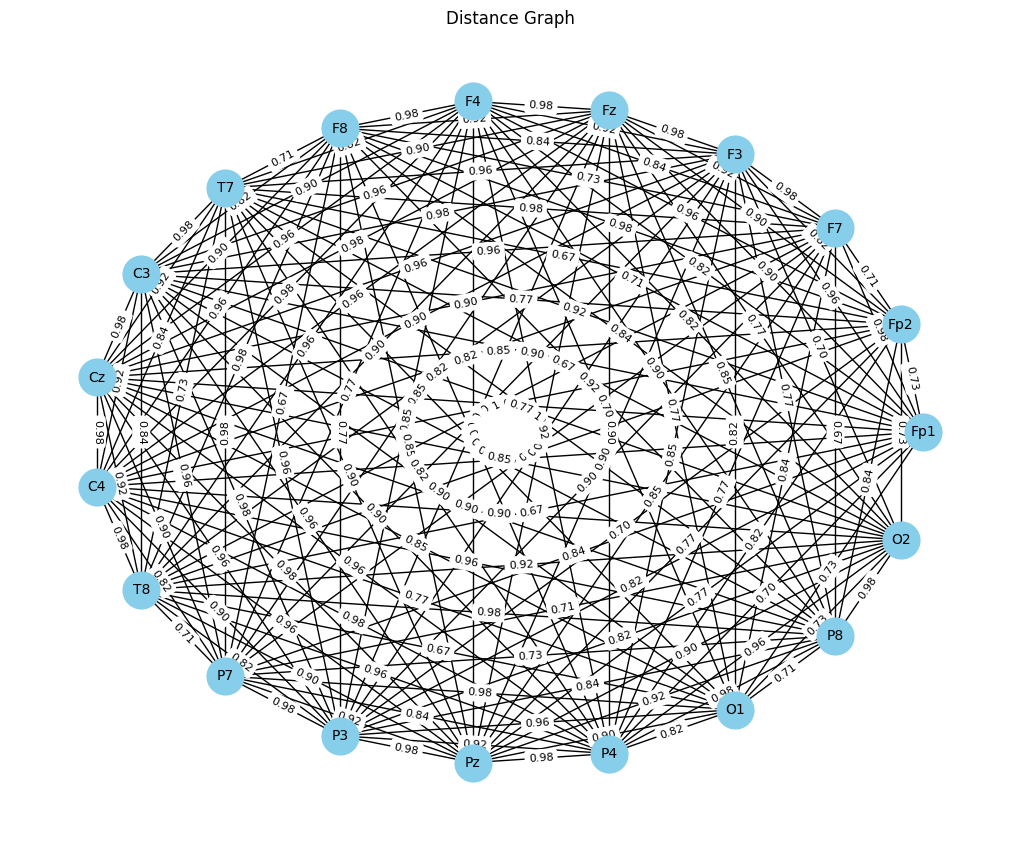

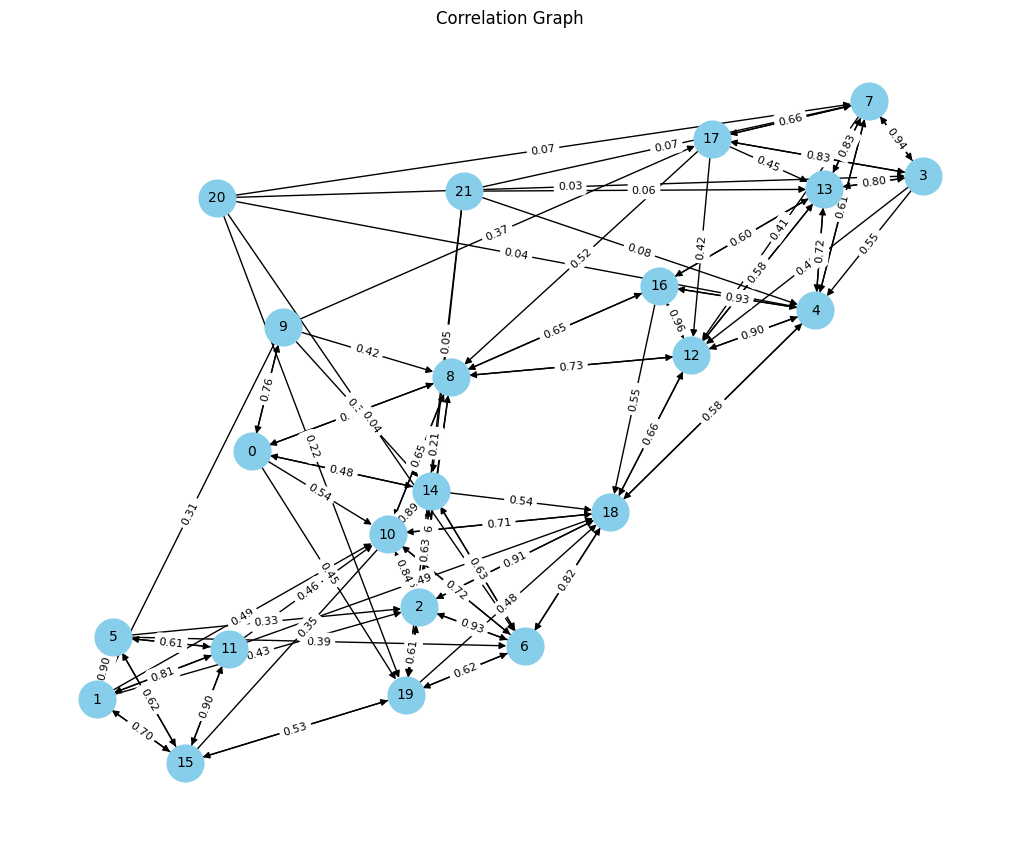

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(G, title, layout='spring'):
    plt.figure(figsize=(10, 8))

    # Choose layout based on the graph type
    if layout == 'spring':
        pos = nx.spring_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)

    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_color="black")
    weights = nx.get_edge_attributes(G, 'weight')

    # Format edge labels for readability
    formatted_weights = {k: f'{v:.2f}' for k, v in weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_weights, font_size=8)

    plt.title(title)
    plt.show()

# Visualize the Distance Graph with a circular layout
visualize_graph(distance_graph, 'Distance Graph', layout='circular')

# Visualize the Correlation Graph with a spring layout
visualize_graph(correlation_graph, 'Correlation Graph', layout='spring')


Self Supervised Pre - Training

In [20]:
!pip install torch torchvision torchaudio --index-binary=pypi
!pip install dgl # Install DGL for graph neural networks
!pip install pytorch-lightning # For training management


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --index-binary
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 30.2 MB/s eta 0:00:00


In [26]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GatedGraphConv
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import numpy as np

# Get adjacency matrices from the graphs
distance_adj_matrix = nx.adjacency_matrix(distance_graph).todense()
correlation_adj_matrix = nx.adjacency_matrix(correlation_graph).todense()

# Convert adjacency matrices to PyTorch Geometric format
edge_index_spatial = torch.tensor(np.array(distance_adj_matrix.nonzero()), dtype=torch.long)
edge_index_functional = torch.tensor(np.array(correlation_adj_matrix.nonzero()), dtype=torch.long)

# Define the DCGRU model
class DCGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(DCGRU, self).__init__()
        self.diff_conv_spatial = GCNConv(input_dim, hidden_dim)
        self.diff_conv_functional = GCNConv(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_spatial, edge_index_spatial, x_functional, edge_index_functional):
        # Spatial graph processing
        spatial_out = F.relu(self.diff_conv_spatial(x_spatial, edge_index_spatial))

        # Functional graph processing
        functional_out = F.relu(self.diff_conv_functional(x_functional, edge_index_functional))

        # Concatenate spatial and functional outputs
        combined = torch.cat((spatial_out, functional_out), dim=1)

        # Add a temporal dimension for GRU
        combined = combined.unsqueeze(1)
        gru_out, _ = self.gru(combined)

        # Output from the last GRU time step
        out = self.fc(gru_out[:, -1, :])
        return out

# Task-Specific Decoder for different pre-training tasks
class TaskSpecificDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super(TaskSpecificDecoder, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.contrastive_loss = nn.CosineEmbeddingLoss()

    def masked_signal_prediction(self, predictions, targets):
        return self.mse_loss(predictions, targets)

    def next_step_prediction(self, predictions, targets):
        return self.mse_loss(predictions, targets)

    def contrastive_learning(self, embeddings1, embeddings2, labels):
        return self.contrastive_loss(embeddings1, embeddings2, labels)

data_loader = DataLoader(data_filtered, batch_size=32, shuffle=True)

# Training loop
def train(model, decoder, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()

        x_spatial, edge_index_spatial, x_functional, edge_index_functional = data

        # Move to device (GPU/CPU)
        x_spatial = x_spatial.to(device)
        edge_index_spatial = edge_index_spatial.to(device)
        x_functional = x_functional.to(device)
        edge_index_functional = edge_index_functional.to(device)

        # Forward pass
        output = model(x_spatial, edge_index_spatial.to(device), x_functional, edge_index_functional.to(device))
        # Dummy targets for illustration (replace with actual targets)
        target_masked = torch.rand_like(output)
        target_next = torch.rand_like(output)
        labels = torch.ones(output.size(0))

        # Compute losses
        mask_loss = decoder.masked_signal_prediction(output, target_masked.to(device))
        next_step_loss = decoder.next_step_prediction(output, target_next.to(device))
        contrastive_loss = decoder.contrastive_learning(output, target_next.to(device), labels.to(device))

        # Combine losses
        loss = mask_loss + next_step_loss + contrastive_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Model, decoder, optimizer setup
input_dim = 32
hidden_dim = 64
output_dim = 32
num_layers = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dcgru_model = DCGRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
decoder = TaskSpecificDecoder(hidden_dim).to(device)
optimizer = torch.optim.Adam(dcgru_model.parameters(), lr=0.001)

# Train the model (example)
num_epochs = 10
for epoch in range(num_epochs):
    loss = train(dcgru_model, decoder, data_loader, optimizer, device)
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')


ValueError: too many values to unpack (expected 4)